# EE1005 Mini-Project: Fake Jobs Posting Prediction
## Group 9:
  1. Nguyen Minh Duc
  2. Ian Teh Jiazhi
  3. Luong Quang Tuan
  4. Benard Teh Wei Hao
  
The source of our dataset is from Kaggle: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction






## PROBLEM STATEMENT

Employment scams are on the rise. 
According to CNBC, the number of employment scams doubled in 2018 as compared to 2017. Economic stress and the coronavirus impact have significantly reduced job availability and job loss for many individuals. This lead to high unemployment rate.
In addition, the scams on job postings allow scammers to gain access to personal information, such as bank account details.Many people are falling prey to these scammers using the desperation that is caused by an unprecedented incident. 

### Hence, with classification model and the use of Natural Language Processing (NLP) , we aim to find an effective model that separate fraudulent and real job postings.

### I. Installing Essential Library

In [1]:
!pip install -U spacy

In [2]:
!pip install wordcloud

In [3]:
#In order to work with english words we have to install the following

!pip install spacy && python -m spacy download en

[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Import required libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import string
import random

Import Scikit-learn libraries to work with the models

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

Import Natural Language Processing libraries

In [6]:
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

## II. Exploratory Data Analysis

Overview of the file

In [7]:
#Import the file
data = pd.read_csv('fake_job_postings.csv',error_bad_lines=False, engine="python")
#Overview
data.head()

C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


Data Statistics

In [8]:
data.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


This implies that the data is highly unstructured

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

There are various d-types.

Check for missing values


In [10]:
#Check missing values
data.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

<AxesSubplot:>

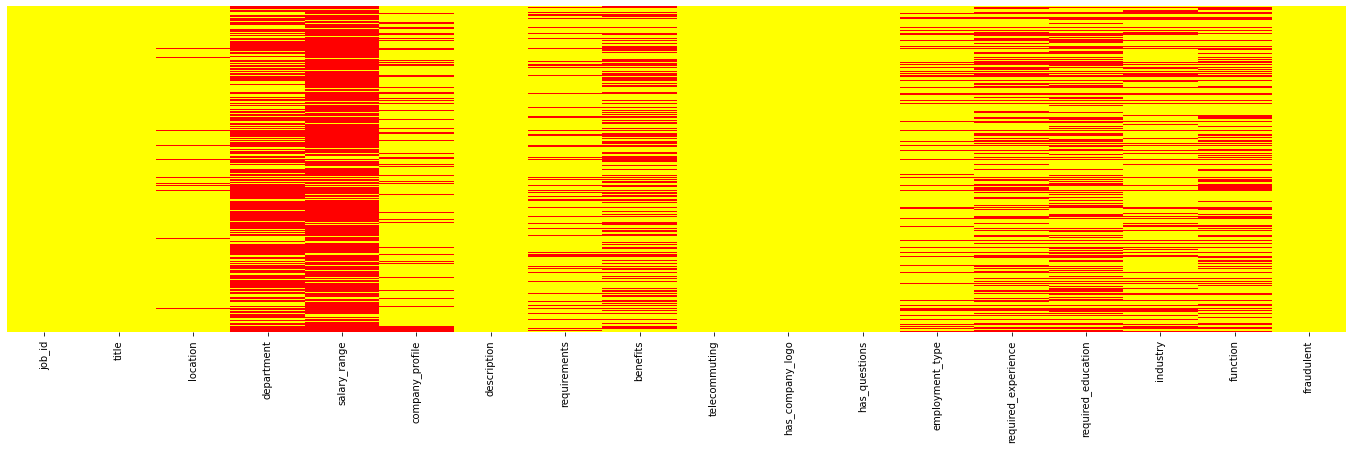

In [11]:
# Visualize The Completeness Of Data
plt.figure(figsize=(24, 6))
sb.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='autumn_r')

We find out that department, salary_range, company_profile,requirements, benefits, employment_type, requirement_experience, require_education, industry, function contain many missing values.

Fill in Missing Values

In [12]:
#Filing blanks
data.fillna('',inplace=True)

In [13]:
#To delete the columns that we do not use
columns = ['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type']
for colu in columns:
    del data[colu]
#Review data
data.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


After the overview, we proposed and found out some interesting features:

#### 1. What percentage does fake job postings account for?

Check for the numbers of fraudulent jobs

In [14]:
data.groupby('fraudulent')['fraudulent'].count()

fraudulent
0    17014
1      866
Name: fraudulent, dtype: int64

Visualize the data

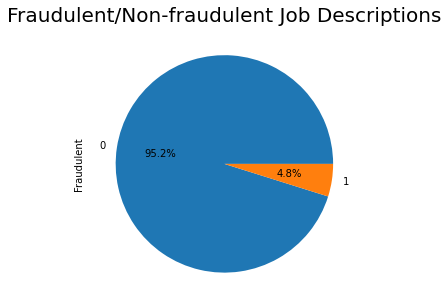

In [15]:
fraud = data.groupby('fraudulent').size()
plt.figure(figsize=(15,5))
plt.title('Fraudulent/Non-fraudulent Job Descriptions', size=20)
fraud.plot(kind='pie', subplots=True, autopct='%.1f%%')
plt.ylabel("Fraudulent")
plt.show()

This graph shows that fake job postings account for nearly 5% of total job postings.
However, the data is very unbalanced (bias toward non-fradulent jobs)

#### 2. How does experience relate to fake jobs?

In [16]:
experience = data[data['required_experience'].notna()]
experience

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,Mid-Senior level,,Computer Software,Sales,0
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,,,,,0
17878,Graphic Designer,"NG, LA, Lagos",,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,Not Applicable,Professional,Graphic Design,Design,0


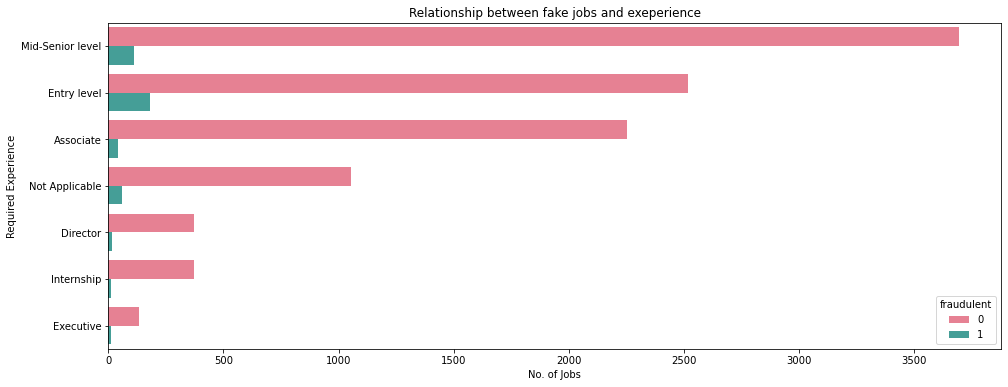

In [17]:
# checks which level is mostly required for fraudulent postings
plt.figure(figsize=(16,6))
sb.countplot(y='required_experience', data=experience, hue="fraudulent", order=data['required_experience'].value_counts().iloc[1:10].index, palette="husl")

plt.xticks(rotation=0)
title = 'Relationship between fake jobs and exeperience'
plt.ylabel('Required Experience', size=10)
plt.xlabel('No. of Jobs', size=10)
plt.title(title)
plt.show()

This graph show that under experience, Mid-Senior level and Entry Level appear the most and for Excutive appear the least.

#### 3. Which countries have the biggest amount of fake job postings?

In [18]:
#Split each location row when they appoach ',' to obtain their Country
def split(location):
    l = location.split(',')
    return l[0]
data['country'] = data.location.apply(split)

In [19]:
data.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [20]:
#Check in the dataframe each country appear how nmany times & top 14 countries appear the most
country = data[data['country'].notna()]
country

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,Mid-Senior level,,Computer Software,Sales,0,CA
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,,,,,0,US
17878,Graphic Designer,"NG, LA, Lagos",,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,Not Applicable,Professional,Graphic Design,Design,0,NG


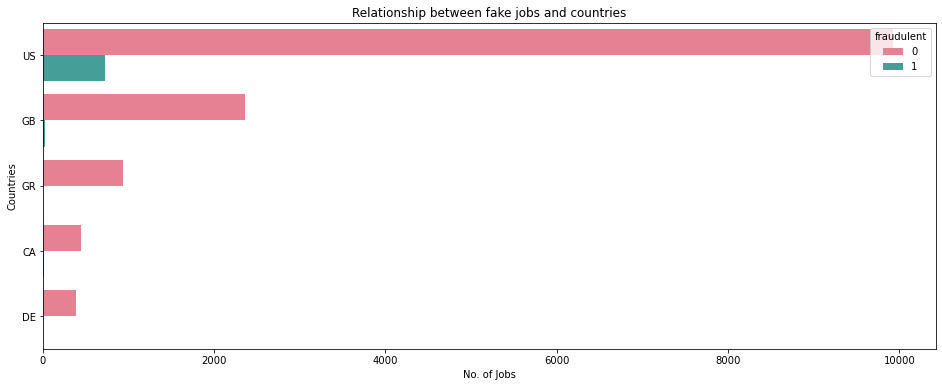

In [21]:
#Plot to visualise the country appear

plt.figure(figsize=(16,6))
sb.countplot(y='country', data=country, hue="fraudulent", order=data['country'].value_counts().iloc[0:5].index, palette="husl")

plt.xticks(rotation=0)
title = 'Relationship between fake jobs and countries'
plt.ylabel('Countries', size=10)
plt.xlabel('No. of Jobs', size=10)
plt.title(title)
plt.show()

This graph shows that US and GB are countries that face the most terrible problems with fake job postings.

#### 4. How does education level relate to fake jobs?

In [22]:
#Checking in the dataframe what are the required education
education = data[data['required_education'].notna()]
education

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,Mid-Senior level,,Computer Software,Sales,0,CA
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,,,,,0,US
17878,Graphic Designer,"NG, LA, Lagos",,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,Not Applicable,Professional,Graphic Design,Design,0,NG


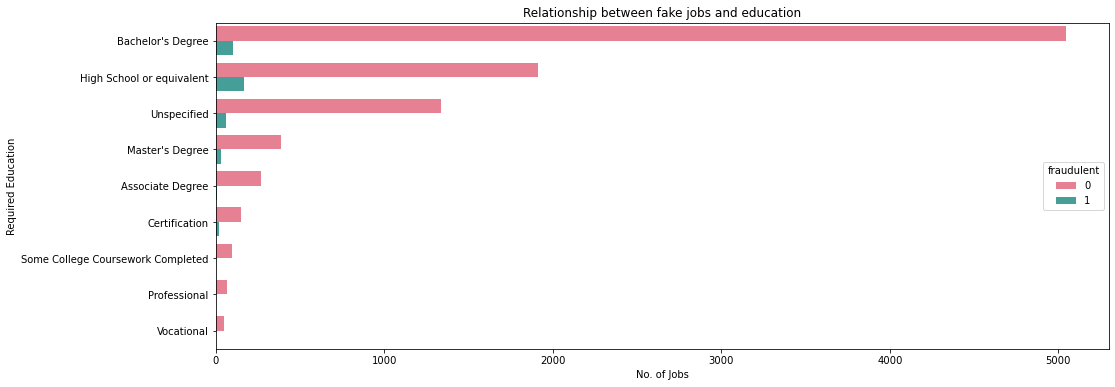

In [23]:
#Plot to visualise the required education

plt.figure(figsize=(16,6))
sb.countplot(y='required_education', data=education, hue="fraudulent", order=data['required_education'].value_counts().iloc[1:10].index, palette="husl")

plt.xticks(rotation=0)
title = 'Relationship between fake jobs and education'
plt.ylabel('Required Education', size=10)
plt.xlabel('No. of Jobs', size=10)
plt.title(title)
plt.show()

This graph shows that a large amount of fake job postings require Bachelor's Degree or High School or equivalent education level.

#### 5. Wordcloud Visualization

Wordcloud is an interesting tool for us to see what are the 'important' words (in terms of appearance frequency). The more the words appear, the more likely it indicates whether the job is fradulent or not

In [24]:
#Check which are not fraudulent

print(data[data.fraudulent == False].title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In [25]:
#Check which are fraudulent

print(data[data.fraudulent == True].title.value_counts()[:10])

Data Entry Admin/Clerical Positions - Work From Home                    21
Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Cruise Staff Wanted *URGENT*                                            21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Account Sales Managers $80-$130,000/yr                                  10
Network Marketing                                                       10
Payroll Clerk                                                           10
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Name: title, dtype: int64


In [26]:
# This is to streamline the data processing later.
# Extract all text data to 2 columm: text and fraud 
data['text'] = data['title']+ ' ' + data['company_profile'] + ' ' + data['description'] + ' ' + data['requirements']+ ' '+ data['benefits']
no_need=['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'required_experience', 'required_education', 'industry', 'function', 'country']
for colu in no_need:
    del data[colu]


In [27]:
data.head()

,fraudulent,text
0,0,"Marketing Intern We're Food52, and we've creat..."
1,0,Customer Service - Cloud Video Production 90 S...
2,0,Commissioning Machinery Assistant (CMA) Valor ...
3,0,Account Executive - Washington DC Our passion ...
4,0,Bill Review Manager SpotSource Solutions LLC i...


In [28]:
#Splitting the dataframe into 2

fraud_text = data[data.fraudulent == True].text
real_text = data[data.fraudulent == False].text

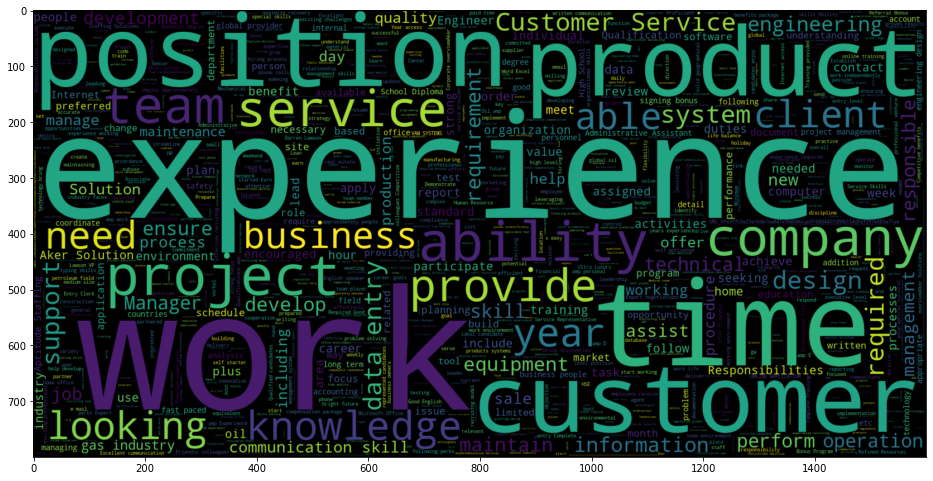

In [29]:
#Create a word cloud for Fake Jobs

STOPWORDS= spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3, max_words = 4000, width = 1600, height = 800, stopwords = STOPWORDS).generate(str(" ".join(fraud_text)))
plt.imshow(wc, interpolation = 'bilinear')

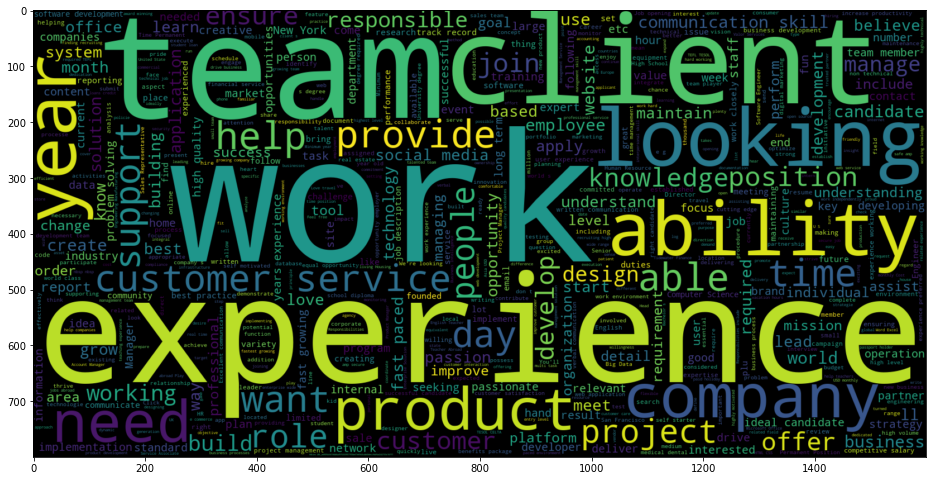

In [30]:
#Create a word cloud for Real Jobs

STOPWORDS= spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3, max_words = 4000, width = 1600, height = 800, stopwords = STOPWORDS).generate(str(" ".join(real_text)))
plt.imshow(wc, interpolation = 'bilinear')

## III. Preprocessing The Data

### 3.1. Down sampling data

Down sampling non-fraudalent data for better training of model

In [103]:
label='fraudulent'

g = data.groupby(label, group_keys=False)
balanced_data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()))).reset_index(drop=True)
balanced_data.head()

,fraudulent,text
0,0,Interface Developer AREA 17 is an interactive ...
1,0,"Dance Instructor-Tumbling, Cheer/Pom Seeking ..."
2,0,"International Broadcaster, Uzbek Language Appl..."
3,0,Video Teleconferencing Engineer VTC National C...
4,0,SAP PP Functional Analyst Description:The SAP...


Checking the number of fraudulent and non-fradulent jobs in the new down-sample

In [69]:
balanced_data.groupby('fraudulent')['fraudulent'].count()

fraudulent
0    866
1    866
Name: fraudulent, dtype: int64

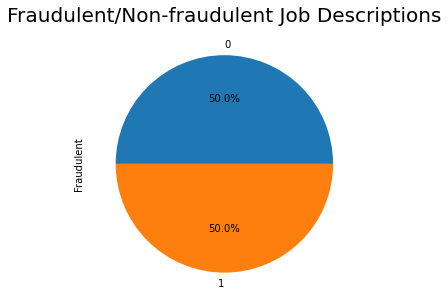

In [102]:
fraud = balanced_data.groupby('fraudulent').size()
plt.figure(figsize=(15,5))
plt.title('Fraudulent/Non-fraudulent Job Descriptions', size=20)
fraud.plot(kind='pie', subplots=True, autopct='%.1f%%')
plt.ylabel("Fraudulent")
plt.show()

### 3.2. Natural Language Processing

Create out list of punctuation marks and stop words








In [70]:
# Create out list of punctuation marks
punctuations = string.punctuation

#Create out list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

Load English tokenizer and create tokenizer function

In [71]:
#Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating out tokenizer function
def spacy_tokenizer(sentence):
    #Creating our token object, which is used to create documents with linguistic annotations
    mytokens = parser(sentence)
    
    #Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    #Removing stop words
    mytockens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    #Return a preprocessed list of tokens
    return mytokens

Basic function to clean text
>  Removing spaces and converting text to lowercase.



In [72]:
#Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercases
    return text.strip().lower()

balanced_data['text'] = balanced_data['text'].apply(clean_text)

Creating a custom transform function to clean up the text

In [73]:
#Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        #Cleaning Text
        return [clean_text(text) for text in X]
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return{}

TF-IDF Vectorizer used to give a numerical value to the words. 

In [74]:
cv = TfidfVectorizer(max_features = 100)
x = cv.fit_transform(balanced_data['text'])
data1 = pd.DataFrame(x.toarray(), columns=cv.get_feature_names())
balanced_data.drop(['text'], axis=1, inplace=True)
main_df = pd.concat([data1,balanced_data], axis=1).reindex(data1.index)

In [75]:
main_df.head(1000)

,ability,able,all,amp,an,and,are,as,at,based,...,who,will,with,within,work,working,years,you,your,fraudulent
0,0.105298,0.082353,0.088083,0.000000,0.025600,0.455826,0.070332,0.072371,0.056265,0.000000,...,0.037523,0.027176,0.251585,0.000000,0.089273,0.065359,0.000000,0.156131,0.029302,0
1,0.000000,0.082125,0.029280,0.032831,0.025529,0.618209,0.046759,0.048114,0.028055,0.000000,...,0.037419,0.000000,0.057898,0.000000,0.022256,0.065179,0.000000,0.000000,0.000000,0
2,0.000000,0.153295,0.000000,0.000000,0.000000,0.339396,0.087279,0.089809,0.000000,0.000000,...,0.000000,0.000000,0.072048,0.152141,0.083088,0.243324,0.116585,0.193751,0.000000,0
3,0.031497,0.000000,0.000000,0.000000,0.068917,0.474493,0.147267,0.238128,0.000000,0.033531,...,0.134689,0.073162,0.069466,0.036673,0.160222,0.058652,0.168612,0.046702,0.000000,0
4,0.034931,0.000000,0.029221,0.000000,0.127385,0.326623,0.069996,0.096033,0.055995,0.037186,...,0.000000,0.000000,0.077040,0.040671,0.066634,0.000000,0.000000,0.103589,0.174967,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.147202,0.139951,0.039231,0.030505,0.651813,0.111747,0.172480,0.033524,0.000000,...,0.000000,0.000000,0.207552,0.000000,0.026595,0.000000,0.000000,0.000000,0.034917,1
996,0.000000,0.126851,0.000000,0.000000,0.000000,0.224680,0.216671,0.000000,0.000000,0.115110,...,0.115596,0.083722,0.178858,0.000000,0.343775,0.000000,0.000000,0.240494,0.090268,1
997,0.034979,0.000000,0.029261,0.000000,0.051024,0.581464,0.000000,0.024041,0.056073,0.000000,...,0.037395,0.000000,0.192866,0.040727,0.088968,0.130272,0.062418,0.000000,0.000000,1
998,0.073906,0.021676,0.154559,0.155972,0.040428,0.575882,0.061706,0.101591,0.014809,0.000000,...,0.019752,0.000000,0.101874,0.043025,0.117485,0.017203,0.049455,0.000000,0.046274,1


Vector Size

In [76]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732 entries, 0 to 1731
Columns: 101 entries, ability to fraudulent
dtypes: float64(100), int64(1)
memory usage: 1.3 MB


## IV. Training The Model

The data is unstructured so we use classification models to work with the data.

For this part, we try different models to see which one brings the best results.
The algorithms that we use are:
  1. Random Forest Algorithm
  2. K-Nearest Neighbors Classification Algorithm
  3. Logistic Regression Algorithm


Divide the dataset into train and test set

In [77]:
Y = main_df['fraudulent']
X = main_df.iloc[:,: -1]

X_train, X_test, y_train, y_test = train_test_split (X,Y, test_size=0.3)


Check the shape of the train set and test set.

In [78]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1212, 100)
(1212,)
(520, 100)
(520,)


### 4.1 Using K-Nearest Neighbors (KNN) Classification

Standardize features by removing the mean and scaling to unit variance.

In [79]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Instantiate and train the model

In [80]:
knc = KNeighborsClassifier(n_neighbors = 15)
knc.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

Fit the model into test data

In [81]:
y_pred = knc.predict(X_test)

Accuracy Analysis

In [82]:
acc1 = accuracy_score(y_test, y_pred)
prc1 = precision_score(y_test, y_pred)
rcl1 = recall_score(y_test, y_pred)
f1_1 = f1_score(y_test, y_pred)

print(acc1)
print(prc1)
print(rcl1)
print(f1_1)

0.8134615384615385
0.8532110091743119
0.7410358565737052
0.7931769722814499


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       269
           1       0.85      0.74      0.79       251

    accuracy                           0.81       520
   macro avg       0.82      0.81      0.81       520
weighted avg       0.82      0.81      0.81       520

Accuracy: 0.8134615384615385


<AxesSubplot:>

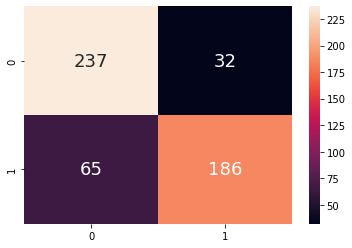

In [83]:
#Classification report
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)

#Putting accuracy we obtain into Confusion Matrix
sb.heatmap(confusion_matrix(y_test,y_pred), annot = True, fmt=".0f", annot_kws={"size": 18})

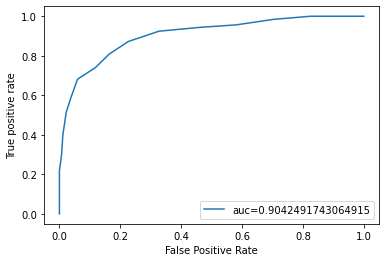

In [84]:
#ROC
y_pred_proba = knc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.xlabel("False Positive Rate", size=10)
plt.ylabel("True positive rate", size=10)
plt.legend(loc=4)
plt.show()

### 4.2. Using Logistic Regression Classification

Instantiate the model and fit the model with data

In [85]:
logreg = LogisticRegression(random_state=16)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=16)

Fit the test data into the model

In [86]:
y_pred = logreg.predict(X_test)

In [87]:
acc2 = accuracy_score(y_test, y_pred)
prc2 = precision_score(y_test, y_pred)
rcl2 = recall_score(y_test, y_pred)
f1_2 = f1_score(y_test, y_pred)

print(acc2)
print(prc2)
print(rcl2)
print(f1_2)

0.7903846153846154
0.7730769230769231
0.8007968127490039
0.7866927592954989


Classification Report

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       269
           1       0.77      0.80      0.79       251

    accuracy                           0.79       520
   macro avg       0.79      0.79      0.79       520
weighted avg       0.79      0.79      0.79       520



<AxesSubplot:>

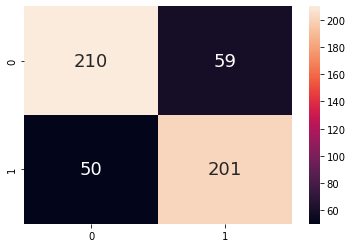

In [88]:
#Classification reports
print("Classification Report\n")
print(classification_report(y_test, y_pred))

#Confusion Matrix
sb.heatmap(confusion_matrix(y_test,y_pred), annot = True, fmt=".0f", annot_kws={"size": 18})

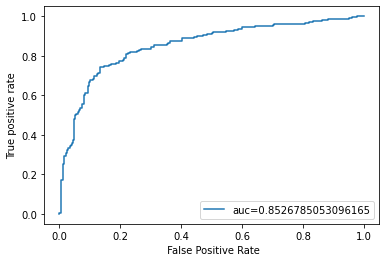

In [89]:
#ROC
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.xlabel(" False Positive Rate", size=10)
plt.ylabel("True positive rate", size=10)
plt.legend(loc=4)
plt.show()

###  4.3. Using Random Forest Classification



Instantiate and train the model (using the default parameters)

In [90]:
rfc = RandomForestClassifier(n_jobs=3, oob_score=True,n_estimators=100,criterion="entropy")
rfc.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_jobs=3, oob_score=True)

Fit the model into test data

In [91]:
y_pred = rfc.predict(X_test)

Accuracy Analysis

In [92]:
acc3 = accuracy_score(y_test, y_pred)
prc3 = precision_score(y_test, y_pred)
rcl3 = recall_score(y_test, y_pred)
f1_3 = f1_score(y_test, y_pred)

print(acc3)
print(prc3)
print(rcl3)
print(f1_3)

0.8211538461538461
0.8038461538461539
0.8326693227091634
0.8180039138943249


In [93]:
#Classification Report
print("Classification Report\n")
print(classification_report(y_test, y_pred))

Classification Report

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       269
           1       0.80      0.83      0.82       251

    accuracy                           0.82       520
   macro avg       0.82      0.82      0.82       520
weighted avg       0.82      0.82      0.82       520



<AxesSubplot:>

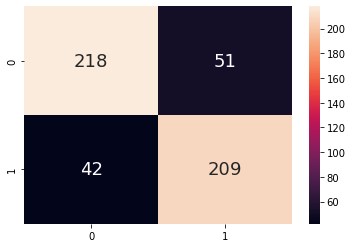

In [94]:
#Confusion Matrix
sb.heatmap(confusion_matrix(y_test,y_pred),annot = True, fmt=".0f", annot_kws={"size": 18})

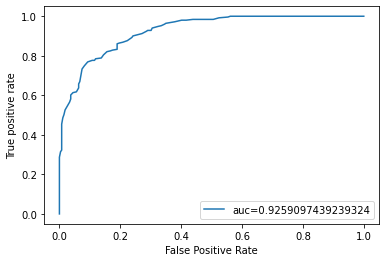

In [95]:
#ROC
y_pred_proba = rfc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.xlabel("False Positive Rate", size=10)
plt.ylabel("True positive rate", size=10)
plt.legend(loc=4)
plt.show()


# V. Compare the models:

Merge all the needed information

In [96]:
ClsModel = [('KNN', acc1, prc1, rcl1,f1_1),('Logistics', acc2, prc2, rcl2,f1_2),('Random Forest', acc3, prc3, rcl3,f1_3),]

In [97]:
# Create table to compare the efficiency of the models
Compare = pd.DataFrame(data = ClsModel, columns=['Model', 'Accuracy', 'Precision' , 'Recall', 'F1'])
Compare

,Model,Accuracy,Precision,Recall,F1
0,KNN,0.813462,0.853211,0.741036,0.793177
1,Logistics,0.790385,0.773077,0.800797,0.786693
2,Random Forest,0.821154,0.803846,0.832669,0.818004


Compare accuracy of the models

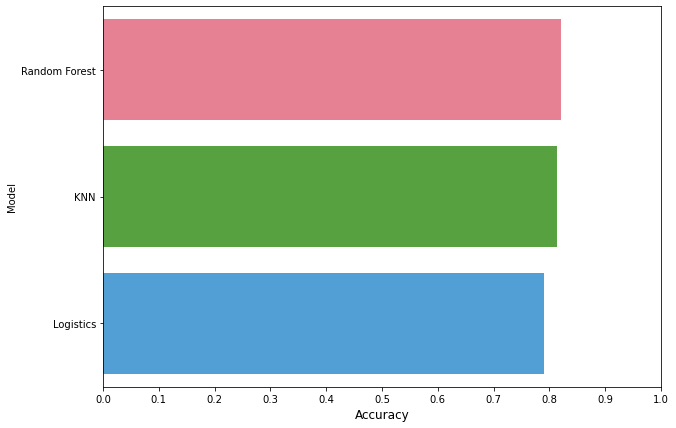

In [98]:
Compare.sort_values(by=['Accuracy'], ascending=False, inplace=True)

f, axes = plt.subplots(1,figsize=(10,7))

sb.barplot(x='Accuracy', y='Model', data = Compare, palette='husl', ax = axes)
axes.set_xlabel('Accuracy', size=12)
axes.set_ylabel('Model')
axes.set_xlim(0,1.0)
axes.set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

Compare precision of the models. Precision suggest the ratio between true fradulent and total predicted fradulent 

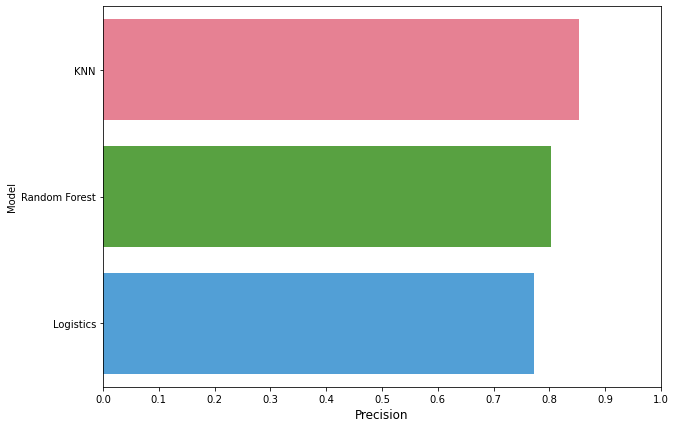

In [99]:
Compare.sort_values(by=['Precision'], ascending=False, inplace=True)

f, axes = plt.subplots(1,figsize=(10,7))

sb.barplot(x='Precision', y='Model', data = Compare, palette='husl', ax = axes)
axes.set_xlabel('Precision', size=12)
axes.set_ylabel('Model')
axes.set_xlim(0,1.0)
axes.set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

Compare recall of the models. Precision suggest the ratio between true fradulent and total actual fradulent

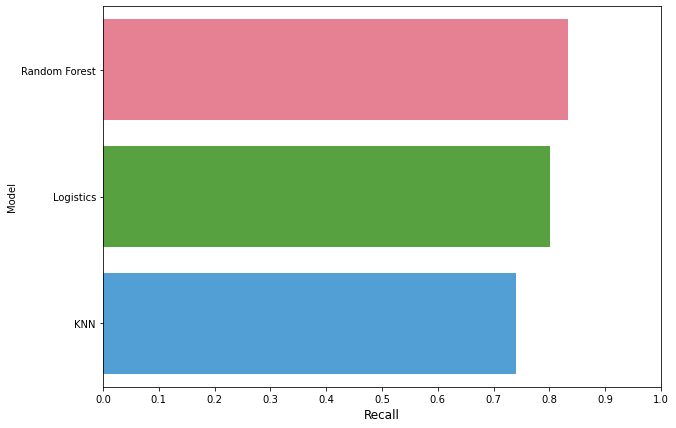

In [100]:
Compare.sort_values(by=['Recall'], ascending=False, inplace=True)

f, axes = plt.subplots(1,figsize=(10,7))

sb.barplot(x='Recall', y='Model', data = Compare, palette='husl', ax = axes)
axes.set_xlabel('Recall', size=12)
axes.set_ylabel('Model')
axes.set_xlim(0,1.0)
axes.set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

Compare F1 score of the models. F1 suggests the imbalacne between precision and recall

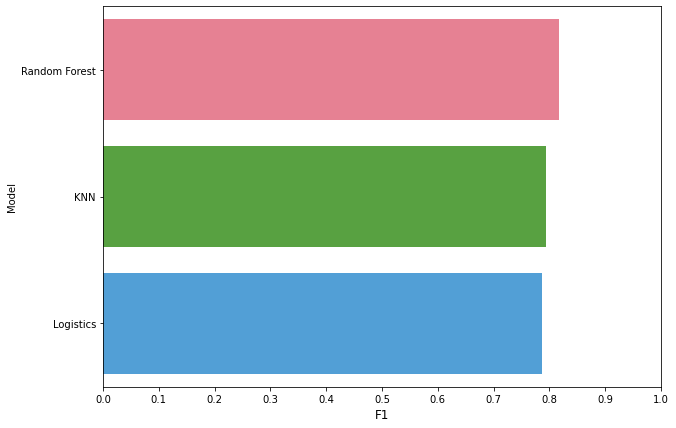

In [101]:
Compare.sort_values(by=['F1'], ascending=False, inplace=True)

f, axes = plt.subplots(1,figsize=(10,7))

sb.barplot(x='F1', y='Model', data = Compare, palette='husl', ax = axes)
axes.set_xlabel('F1', size=12)
axes.set_ylabel('Model')
axes.set_xlim(0,1.0)
axes.set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

In the end, it is seen that Random Forest is the best model to predict the fradulent jobs since it has the highest score in most categories. It further implies that random forest is a good algorithm to handle with very unstructured dataset.
We have already accomplished our aim to choose the model that best predict the fradulent job from a list of job advertisements.